In [1]:
%%capture
!pip install -U pip albumentations==0.4.5 pytorch-lightning
!pip install efficientnet-pytorch
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [2]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
from random import shuffle
import albumentations as A
import torch
torch.__version__
from torch import nn
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
from torchvision.datasets import STL10
import torchvision.transforms.functional as tvf
from torchvision import transforms
import pandas as pd
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, SequentialSampler
from PIL import Image
from torch.multiprocessing import cpu_count
from torch.optim import RMSprop
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from argparse import Namespace
import xml.etree.ElementTree as ET

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DATASET

In [ ]:
img_dirs = []
labels = []
files_cervix = os.listdir("/workstation/raid/home/p170059cs/bijoy_backup/data_from_b170007ec/Datasets/Cervix Cancer/train/train")
files_cervix = sorted(files_cervix)
for i in files_cervix[1:]:
    path = "/workstation/raid/home/p170059cs/bijoy_backup/data_from_b170007ec/Datasets/Cervix Cancer/train/train/"+ str(i)
    sub = os.listdir(path)
    sub = sorted(sub)
    for j in sub[1:]:
        sub_path = path + "/" + str(j)
        img_dirs.append(sub_path)
        labels.append("Cervix")
        
print("Cervical images done")

blood = os.listdir("/workstation/raid/home/p170059cs/bijoy_backup/data_from_b170007ec/Programs/Bhanu/SCLEARNING/Blood_images/train")
blood = sorted(blood)
for l in blood:
    if l != ".ipynb_checkpoints":
        path = "/workstation/raid/home/p170059cs/bijoy_backup/data_from_b170007ec/Programs/Bhanu/SCLEARNING/Blood_images/train/" + str(l)
        img = Image.open(path)
        t2 = transforms.ToTensor()(img)
        if t2.shape[0] == 3:
            img_dirs.append(path)
            labels.append("Blood")  
            
blood1 = os.listdir("/workstation/raid/home/p170059cs/bijoy_backup/data_from_b170007ec/Programs/Bhanu/SCLEARNING/Blood_images/val")
blood1 = sorted(blood1)
for l1 in blood1:
    if l1 != ".ipynb_checkpoints":
        path = "/workstation/raid/home/p170059cs/bijoy_backup/data_from_b170007ec/Programs/Bhanu/SCLEARNING/Blood_images/val/" + str(l1)
        img = Image.open(path)
        t2 = transforms.ToTensor()(img)
        if t2.shape[0] == 3:
            img_dirs.append(path)
            labels.append("Blood")
            
print("Blood images done")
            
eye = os.listdir("/workstation/raid/home/p170059cs/bijoy_backup/data_from_b170007ec/Programs/Bhanu/SCLEARNING/eye_dataset")
eye = sorted(eye)
for m in eye:
    if m != ".ipynb_checkpoints":
        path = "/workstation/raid/home/p170059cs/bijoy_backup/data_from_b170007ec/Programs/Bhanu/SCLEARNING/eye_dataset/" + str(m)
        img = Image.open(path)
        t2 = transforms.ToTensor()(img)
        if t2.shape[0] == 3:
            img_dirs.append(path)
            labels.append("Eye")  
            
print("Eye images done")
        
skin = os.listdir("/workstation/raid/home/p170059cs/bijoy_backup/data_from_b170007ec/Programs/Bhanu/SCLEARNING/skin_cancer")
skin = sorted(skin)
for n in skin:
    if n != ".ipynb_checkpoints":
        path = "/workstation/raid/home/p170059cs/bijoy_backup/data_from_b170007ec/Programs/Bhanu/SCLEARNING/skin_cancer/" + str(n)
        img = Image.open(path)
        t2 = transforms.ToTensor()(img)
        if t2.shape[0] == 3:
            img_dirs.append(path)
            labels.append("Skin")  

print("Skin images done")
            
surgery = os.listdir("/workstation/raid/home/p170059cs/bijoy_backup/data_from_b170007ec/Programs/Bhanu/SCLEARNING/Surgery_frames")
surgery = sorted(surgery)
for o in surgery:
    if o != ".ipynb_checkpoints":
        path = "/workstation/raid/home/p170059cs/bijoy_backup/data_from_b170007ec/Programs/Bhanu/SCLEARNING/Surgery_frames/" + str(o)
        img = Image.open(path)
        t2 = transforms.ToTensor()(img)
        if t2.shape[0] == 3:
            img_dirs.append(path)
            labels.append("Surgery")  
            
print("Surgery images done")

Imagenet = os.listdir("/workstation/raid/home/p170059cs/bijoy_backup/data_from_b170007ec/Programs/Bhanu/CERVICAL2.0/Imagenet/train")
Imagenet = sorted(Imagenet)
for k in Imagenet:
    if k != ".ipynb_checkpoints":
        folder = "/workstation/raid/home/p170059cs/bijoy_backup/data_from_b170007ec/Programs/Bhanu/CERVICAL2.0/Imagenet/train/" + str(k)
        images = os.listdir(folder)
        for image in images:
            if image != ".ipynb_checkpoints":
                path = folder + "/" +str(image)
                img = Image.open(path)
                t2 = transforms.ToTensor()(img)
                label = str(k)
                if t2.shape[0] == 3:
                    img_dirs.append(path)
                    labels.append(label)  
            
Imagenet1 = os.listdir("/workstation/raid/home/p170059cs/bijoy_backup/data_from_b170007ec/Programs/Bhanu/CERVICAL2.0/Imagenet/val")
Imagenet1 = sorted(Imagenet1)
for k1 in Imagenet1:
    if k1 != ".ipynb_checkpoints":
        path = "/workstation/raid/home/p170059cs/bijoy_backup/data_from_b170007ec/Programs/Bhanu/CERVICAL2.0/Imagenet/val/" + str(k1)
        img = Image.open(path)
        t2 = transforms.ToTensor()(img)
        tree = ET.parse("/workstation/raid/home/p170059cs/bijoy_backup/data_from_b170007ec/Programs/Bhanu/SCLEARNING/Imagenet/labels/" + str(k1)[:-4] + "xml")
        root = tree.getroot()
        label = root.findall('./object/name')[0].text
        if t2.shape[0] == 3:
            img_dirs.append(path)
            labels.append(label)

In [ ]:
df2 = pd.DataFrame({"path":img_dirs,"label":labels})
df2['id'] = df2.groupby(['label']).ngroup()
df2.to_csv("/workstation/raid/home/p170059cs/bijoy_backup/data_from_b170007ec/Programs/Bhanu/CERVICAL2.0/Dataset/Dataset1.csv")

In [ ]:
train_df,val_df = train_test_split(df2, test_size=0.1, random_state=42,shuffle = True,stratify = df2["id"])
train_df.to_csv("/workstation/raid/home/p170059cs/bijoy_backup/data_from_b170007ec/Programs/Bhanu/CERVICAL2.0/Dataset/train_dataset1.csv")
val_df.to_csv("/workstation/raid/home/p170059cs/bijoy_backup/data_from_b170007ec/Programs/Bhanu/CERVICAL2.0/Dataset/val_dataset1.csv")

DATASET

In [3]:
train_df = pd.read_csv("/workstation/raid/home/p170059cs/data_from_b170007ec/Programs/Bhanu/CERVICAL2.0/Dataset/Dataset1.csv")
img_dirs = list(train_df["path"])
for i in range(len(img_dirs)):
    img_dirs[i] = img_dirs[i].replace("/workstation/raid/home/p170059cs/bijoy_backup/data_from_b170007ec","/workstation/raid/home/p170059cs/data_from_b170007ec")
labels = list(train_df["id"])

print("Length of total data :", len(img_dirs))
# temp = list(zip(img_dirs, labels))
# random.shuffle(temp)
# data, labels = zip(*temp)
data = img_dirs

Length of total data : 1331784


LOSS

In [4]:
class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask
        
        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))
       
        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
     
        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [5]:
def random_rotate(image):
    if random.random() > 0.5:
        return tvf.rotate(image, angle=random.choice((0, 90, 180, 270)))
    return image

class ResizedRotation():
    def __init__(self, angle, output_size=(512,512)):
        self.angle = angle
        self.output_size = output_size
        
    def angle_to_rad(self, ang): return np.pi * ang / 180.0
        
    def __call__(self, image):
        w, h = image.size
        new_h = int(np.abs(w * np.sin(self.angle_to_rad(90 - self.angle))) + np.abs(h * np.sin(self.angle_to_rad(self.angle))))
        new_w = int(np.abs(h * np.sin(self.angle_to_rad(90 - self.angle))) + np.abs(w * np.sin(self.angle_to_rad(self.angle))))
        img = tvf.resize(image, (new_w, new_h))
        img = tvf.rotate(img, self.angle)
        img = tvf.center_crop(img, self.output_size)
        return img
    
class WrapWithRandomParams():
    def __init__(self, constructor, ranges):
        self.constructor = constructor
        self.ranges = ranges
    
    def __call__(self, image):
        randoms = [float(np.random.uniform(low, high)) for _, (low, high) in zip(range(len(self.ranges)), self.ranges)]
        return self.constructor(*randoms)(image)
    
class PretrainingDatasetWrapper(Dataset):
    def __init__(self, ds: Dataset, l: labels, target_size=(512,512), debug=False):
        super().__init__()
        self.ds = ds
        self.labels = l
        self.debug = debug
        self.target_size = target_size
        if debug:
            print("DATASET IN DEBUG MODE")
        
        self.preprocess = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        random_resized_rotation = WrapWithRandomParams(lambda angle: ResizedRotation(angle, target_size), [(0.0, 360.0)])
        self.randomize = transforms.Compose([
            transforms.RandomResizedCrop(target_size, scale=(340/512, 340/512), ratio=(1.0, 1.0)),
            transforms.RandomChoice([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Lambda(random_rotate)
            ]),
            transforms.RandomApply([
                random_resized_rotation
            ], p=0.6),
            transforms.RandomApply([
                transforms.ColorJitter(brightness=0.5, contrast=0.6, saturation=0.6, hue=0.3)
            ], p=0.8)
        ])
    
    def __len__(self): return len(self.ds)
    
    def __getitem_internal__(self, idx, preprocess=True):
        this_image_raw_path = self.ds[idx]
        label = self.labels[idx]
        this_image_raw = Image.open(this_image_raw_path)
        if self.debug:
            random.seed(idx)
            t1 = self.randomize(this_image_raw)
            random.seed(idx + 1)
            t2 = self.randomize(this_image_raw)
        else:
            t1 = self.randomize(this_image_raw)
            t2 = self.randomize(this_image_raw)
        
        if preprocess:
            t1 = self.preprocess(t1)
            t2 = self.preprocess(t2)
        else:
            t1 = transforms.ToTensor()(t1)
            t2 = transforms.ToTensor()(t2)
            
        return (t1, t2), torch.tensor(label)

    def __getitem__(self, idx):
        return self.__getitem_internal__(idx, True)
    
    def raw(self, idx):
        return self.__getitem_internal__(idx, False)
    
    
from efficientnet_pytorch import EfficientNet
class ImageEmbedding(nn.Module):       
    class Identity(nn.Module):
        def __init__(self): super().__init__()

        def forward(self, x):
            return x
    
        
    def __init__(self, embedding_size=1024):
        super().__init__()
        
        base_model = EfficientNet.from_pretrained("efficientnet-b2")
        internal_embedding_size = base_model._fc.in_features
        base_model._fc = ImageEmbedding.Identity()
        
        self.embedding = base_model
        
        self.projection = nn.Sequential(
            nn.Linear(in_features=internal_embedding_size, out_features=embedding_size),
            nn.ReLU(),
            nn.Linear(in_features=embedding_size, out_features=embedding_size)
        )

    def calculate_embedding(self, image):
        return self.embedding(image)

    def forward(self, X):
        image = X
        embedding = self.calculate_embedding(image)
        projection = self.projection(embedding)
        return embedding, projection

    
class ImageEmbeddingModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.hparams.update(vars(hparams))
        self.model = ImageEmbedding()
        self.loss = SupConLoss()
    
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.epochs
    
    def train_dataloader(self):
        return DataLoader(PretrainingDatasetWrapper(data, labels,
                                             debug=getattr(self.hparams, "debug", False)),
                          batch_size=self.hparams.batch_size,
                          num_workers=4,
                          sampler=SubsetRandomSampler(list(range(hparams.train_size))),
                         drop_last=True)
    
    def val_dataloader(self):
        return DataLoader(PretrainingDatasetWrapper(data, labels,
                                            debug=getattr(self.hparams, "debug", False)),
                          batch_size=self.hparams.batch_size, 
                          shuffle=False,
                          num_workers=4,
                          sampler=SequentialSampler(list(range(hparams.train_size + 1, hparams.train_size + hparams.validation_size))),
                         drop_last=True)
    
    def forward(self, X):
        return self.model(X)
    
    def step(self, batch, step_name = "train"):
        (X, Y), labels = batch
        embX, projectionX = self.forward(X)
        embY, projectionY = self.forward(Y)
        z_i = F.normalize(projectionX , dim=1)
        z_j = F.normalize(projectionY, dim=1)
        projX = torch.reshape(z_i,(z_i.shape[0],1,z_i.shape[1]))
        projY = torch.reshape(z_j,(z_j.shape[0],1,z_j.shape[1]))
        features = torch.cat([projX, projY], dim=1)
        loss = self.loss(features=features,labels=labels)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}
        self.log("loss" if step_name == "train" else loss_key, loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        #return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
                        #"progress_bar": {loss_key: loss}}
        return loss
    
    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")
    
    def validation_end(self, outputs):
        if len(outputs) == 0:
            return {"val_loss": torch.tensor(0)}
        else:
            loss = torch.stack([x["val_loss"] for x in outputs]).mean()
            return {"val_loss": loss, "log": {"val_loss": loss}}

    def configure_optimizers(self):
        optimizer = RMSprop(self.model.parameters(), lr=self.hparams.lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=15, verbose=True)
        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler,
           'monitor': 'val_loss'
       }

In [6]:
ds = PretrainingDatasetWrapper(data, labels)

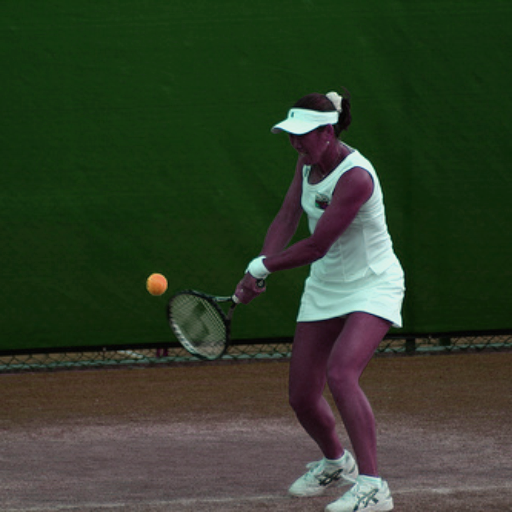

In [234]:
tvf.to_pil_image(ds.raw(971516)[0][1])

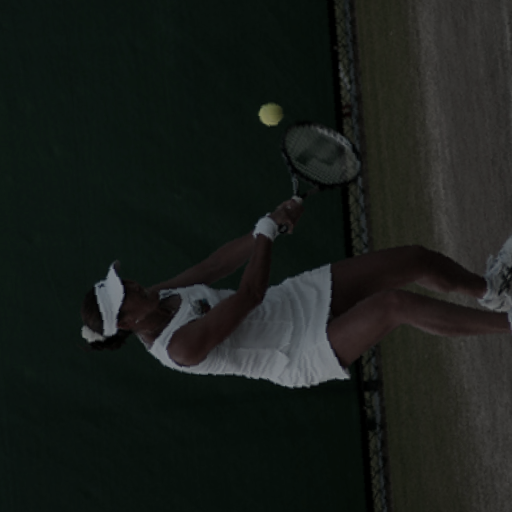

In [208]:
tvf.to_pil_image(ds.raw(971516)[0][0])

In [9]:
hparams = Namespace(
    lr=0.001,
    epochs=200,
    batch_size=27,
    train_size=63580,
    validation_size=7030
)

checkpoint_callback = ModelCheckpoint(
    dirpath="/workstation/raid/home/p170059cs/bijoy_backup/data_from_b170007ec/Programs/Bhanu/CERVICAL2.0/Checkpoints", 
    filename="model", 
    monitor='val_loss',
    verbose=True, 
    save_top_k=1,
    mode='min'
)
early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=10, verbose=1, mode='min')
module = ImageEmbeddingModule(hparams)
trainer = pl.Trainer(gpus = 1,
                     accumulate_grad_batches=512,
                     max_epochs=hparams.epochs,
                     replace_sampler_ddp = False,
                     strategy="dp",
                    callbacks=[checkpoint_callback,early_stop_callback],
                    progress_bar_refresh_rate=20)

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Loaded pretrained weights for efficientnet-b2


In [ ]:
trainer.fit(module)

In [ ]:
labels = torch.tensor([0,1,0,1,0,0,1])

In [7]:
mask = torch.eq(labels, labels.T)

/tmp/ipykernel_1580/3954745458.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2244.)
  mask = torch.eq(labels, labels.T)


In [8]:
mask

tensor([True, True, True, True, True, True, True])

In [ ]:
model = nn.DataParallel(model)